In [1]:
from __future__ import division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
import time
import os
from PIL import Image

from ops import *
from utils import *

Today we are going to train GAN for generating faces and then we will make fun playing with it. Generative adversarial networks (GANs) are deep neural net architectures comprised of two nets, pitting one against the other (thus the “adversarial”). One neural network, called the generator, generates new faces, while the other, the discriminator,  decides whether each instance of face it reviews belongs to the actual training dataset or not.

Firstly download aligned faces of celebrities from here <a href="https://yadi.sk/d/xjuClJJH3MAVXh">link</a> and extract them into folder near ipython notebook.

# Implementation of GAN

Constant variables below depends on your dataset and choosing of architecture.

In [2]:
#DATA_PATH = './aligned_celebA/' # Path to the dataset with celebA faces
DATA_PATH = './img_align_celeba/' 
Z_DIM=100 # Dimension of face's manifold
GENERATOR_DENSE_SIZE=64*8 # Length of first tensor in generator

IMAGE_SIZE=64 # Shapes of input image
BATCH_SIZE=64 # Batch size
N_CHANNELS = 3 # Number channels of input image

MERGE_X = 8 # Number images in merged image

In [3]:
assert(os.path.exists(DATA_PATH)), 'Please, download aligned celebA to DATA_PATH folder'

In [4]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


In [5]:
def get_image(image_path, width, height, mode):
    """
    Read image from image_path
    :param image_path: Path of image
    :param width: Width of image
    :param height: Height of image
    :param mode: Mode of image
    :return: Image data
    """
    image = Image.open(image_path)

    if image.size != (width, height):  # HACK - Check if image is from the CELEBA dataset
        # Remove most pixels that aren't part of a face
        face_width = face_height = 108
        j = (image.size[0] - face_width) // 2
        i = (image.size[1] - face_height) // 2
        image = image.crop([j, i, j + face_width, i + face_height])
        image = image.resize([width, height], Image.BILINEAR)

    return np.array(image.convert(mode))


In [6]:
def get_batch(image_files, width, height, mode):
    data_batch = np.array(
        [get_image(sample_file, width, height, mode) for sample_file in image_files]).astype(np.float32)

    # Make sure the images are in 4 dimensions
    if len(data_batch.shape) < 4:
        data_batch = data_batch.reshape(data_batch.shape + (1,))

    return data_batch

In [7]:
def images_square_grid(images, mode):
    """
    Save images as a square grid
    :param images: Images to be used for the grid
    :param mode: The mode to use for images
    :return: Image of images in a square grid
    """
    # Get maximum size for square grid of images
    save_size = math.floor(np.sqrt(images.shape[0]))

    # Scale to 0-255
    images = (((images - images.min()) * 255) / (images.max() - images.min())).astype(np.uint8)

    # Put images in a square arrangement
    images_in_square = np.reshape(
            images[:save_size*save_size],
            (save_size, save_size, images.shape[1], images.shape[2], images.shape[3]))
    if mode == 'L':
        images_in_square = np.squeeze(images_in_square, 4)

    # Combine images to grid image
    new_im = Image.new(mode, (images.shape[1] * save_size, images.shape[2] * save_size))
    for col_i, col_images in enumerate(images_in_square):
        for image_i, image in enumerate(col_images):
            im = Image.fromarray(image, mode)
            new_im.paste(im, (col_i * images.shape[1], image_i * images.shape[2]))

    return new_im

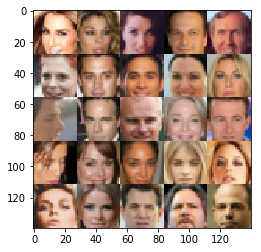

In [8]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = get_batch(glob('./img_align_celeba/*.jpg')[:show_n_images], 28, 28, 'RGB')
plt.imshow(images_square_grid(mnist_images, 'RGB'))

Let's define GAN. To do it, we need to define generator, discriminator and loss functions.

Here are some tips on the architecture of the generator:
1. The deeper is convolution, the less filters is using.
2. Apply deconvolutions-relu layers to achieve input image shape.
3. Use batch normalization before nonlinearity for speed and stability of learning.
4. Use tanh activation at the end of network (in this case images should be scaled to [-1, 1])
5. To force generator not to collapse and produce different outputs initialize bias with zero (see linear layer).

Other useful tips: https://github.com/soumith/ganhacks. Example of architecture see below. You may also use defined layers from ops.py. <b> Please, use names for layers started with "g\_" for generator and "d_" for discriminator.</b>

<img src="https://raw.githubusercontent.com/carpedm20/DCGAN-tensorflow/master/DCGAN.png">

## Writing generator function (1 point)

In [9]:
def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    inputs_l = tf.placeholder(tf.float32, (None), name='input_l')

    return inputs_real, inputs_z, inputs_l

In [10]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not(is_train)):
        # First fully connected layer

        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.2 * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.2 * x2, x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(0.2 * x3, x3)
        # 14x14x128 now
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 3, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(0.2 * x4, x4)
        # 28x28x64 now
        
        x5 = tf.layers.conv2d_transpose(x4, 32, 3, strides=1, padding='same')
        x5 = tf.layers.batch_normalization(x5, training=is_train)
        x5 = tf.maximum(0.2 * x5, x5)
        # 28x28x32 now
        
        x6 = tf.layers.conv2d_transpose(x5, 32, 3, strides=1, padding='same')
        x6 = tf.layers.batch_normalization(x6, training=is_train)
        x6 = tf.maximum(0.2 * x6, x6)
        # 28x28x32 now
        
        x7 = tf.layers.conv2d_transpose(x6, 16, 1, strides=1, padding='same')
        x7 = tf.layers.batch_normalization(x7, training=is_train)
        x7 = tf.maximum(0.2 * x7, x7)
        # 28x28x16 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x7, out_channel_dim, 1, strides=1, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out 

Now let's define discriminator. Discriminator takes 3d tensor as input and outputs one number - probability that this is an image.

Some advice for discriminator's architecture:
1. Use batch normalization between convolutions and nonlinearities.
2. Use leaky relu with the leak about 0.2.
3. The deeper the layer, the more filters you can use.

If you use batch normalization, please define every layer in their own scope and pass is_training parameter there. Or you may use class of batch normalization from ops.py. Do not forget to fratten tensor after the convolution blocks.

## Writing discriminator function (1 point)

In [11]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(0.2 * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(0.2 * bn2, bn2)
        # 7x7x128

        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(0.2 * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

Now let's define generator and discriminator.

Write definition of loss funstions according to formulas:
$$ D\_loss = \frac{-1}{m} \sum_{i=1}^{m}[\log{D(x_i)} + \log{(1 - D(G(z_i)))}]$$
$$ G\_loss = \frac{1}{m} \sum_{i=1}^{m} \log{(1 - D(G(z_i)))}$$

Or for better learning you may try other loss for generator:
$$ G\_loss = \frac{-1}{m} \sum_{i=1}^{m} \log{(D(G(z_i)))}$$

## Writing loss functions (2 points)

In [12]:
"""
        You code goes here. Define discriminator and generator losses
"""
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

In [13]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        # Get weights and bias to update
        t_vars = tf.trainable_variables()
        d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
        g_vars = [var for var in t_vars if var.name.startswith('generator')]

        # Optimize
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

Create optimizers. We use different optimizers for discriminator and generator, so we needed a separate prefix for the discriminator and generator variables (g_ for generator, d_ for disciminator).

In [14]:
def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = images_square_grid(samples, image_mode)
    plt.imshow(images_grid, cmap=cmap)
    plt.show()

Load data:

Functions for training and evaluations.

## Training GAN (1 point + 2 for good results)

In [15]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    # Create the network
    image_channels = out_channel_dim = data_shape[3]
    
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    losses = []
    iteration = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                iteration += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                if iteration % 100 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))  
                    
                if iteration % 1000 == 0:
                    show_generator_output(sess, 25, input_z, out_channel_dim, data_image_mode)

In [16]:
class Dataset(object):
    """
    Dataset
    """
    def __init__(self, dataset_name, data_files):
        """
        Initalize the class
        :param dataset_name: Database name
        :param data_files: List of files in the database
        """
        DATASET_CELEBA_NAME = 'celeba'
        DATASET_MNIST_NAME = 'mnist'
        IMAGE_WIDTH = 28
        IMAGE_HEIGHT = 28

        if dataset_name == DATASET_CELEBA_NAME:
            self.image_mode = 'RGB'
            image_channels = 3

        elif dataset_name == DATASET_MNIST_NAME:
            self.image_mode = 'L'
            image_channels = 1

        self.data_files = data_files
        self.shape = len(data_files), IMAGE_WIDTH, IMAGE_HEIGHT, image_channels

    def get_batches(self, batch_size):
        """
        Generate batches
        :param batch_size: Batch Size
        :return: Batches of data
        """
        IMAGE_MAX_VALUE = 255

        current_index = 0
        while current_index + batch_size <= self.shape[0]:
            data_batch = get_batch(
                self.data_files[current_index:current_index + batch_size],
                *self.shape[1:3],
                self.image_mode)

            current_index += batch_size

            yield data_batch / IMAGE_MAX_VALUE - 0.5

Epoch 1/1... Discriminator Loss: 0.3742... Generator Loss: 2.3232
Epoch 1/1... Discriminator Loss: 1.3257... Generator Loss: 0.6486
Epoch 1/1... Discriminator Loss: 1.2766... Generator Loss: 0.5971
Epoch 1/1... Discriminator Loss: 0.7771... Generator Loss: 1.0148
Epoch 1/1... Discriminator Loss: 0.5967... Generator Loss: 1.0748
Epoch 1/1... Discriminator Loss: 0.6464... Generator Loss: 1.7380
Epoch 1/1... Discriminator Loss: 2.0789... Generator Loss: 0.1822
Epoch 1/1... Discriminator Loss: 1.0681... Generator Loss: 0.8606
Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 0.5247
Epoch 1/1... Discriminator Loss: 1.2620... Generator Loss: 3.6596


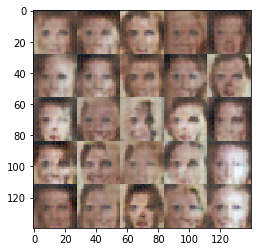

Epoch 1/1... Discriminator Loss: 0.9629... Generator Loss: 0.6190
Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.7867
Epoch 1/1... Discriminator Loss: 0.6339... Generator Loss: 1.2888
Epoch 1/1... Discriminator Loss: 0.7075... Generator Loss: 1.4523
Epoch 1/1... Discriminator Loss: 1.1242... Generator Loss: 0.8952
Epoch 1/1... Discriminator Loss: 0.5090... Generator Loss: 2.2943
Epoch 1/1... Discriminator Loss: 0.5694... Generator Loss: 1.0939
Epoch 1/1... Discriminator Loss: 0.4597... Generator Loss: 3.1043
Epoch 1/1... Discriminator Loss: 0.7583... Generator Loss: 4.5099
Epoch 1/1... Discriminator Loss: 1.6090... Generator Loss: 1.8021


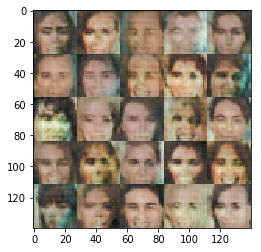

Epoch 1/1... Discriminator Loss: 0.4042... Generator Loss: 3.9123
Epoch 1/1... Discriminator Loss: 0.8147... Generator Loss: 1.4229
Epoch 1/1... Discriminator Loss: 0.3684... Generator Loss: 1.6737
Epoch 1/1... Discriminator Loss: 1.0188... Generator Loss: 1.1871
Epoch 1/1... Discriminator Loss: 1.8182... Generator Loss: 1.8762
Epoch 1/1... Discriminator Loss: 1.1750... Generator Loss: 0.8568
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 3.2816
Epoch 1/1... Discriminator Loss: 0.4708... Generator Loss: 3.0812
Epoch 1/1... Discriminator Loss: 1.8164... Generator Loss: 1.9764
Epoch 1/1... Discriminator Loss: 1.8377... Generator Loss: 0.2293


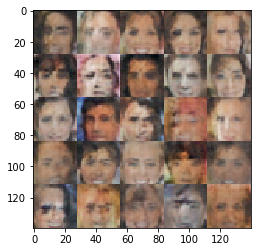

Epoch 1/1... Discriminator Loss: 0.2781... Generator Loss: 1.9186


In [17]:
batch_size = BATCH_SIZE
z_dim = Z_DIM
learning_rate = 0.0005
beta1 = 0.5

epochs = 1

celeba_dataset = Dataset('celeba', glob('./img_align_celeba/*.jpg'))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

If you generated something that looks like a face - it's cool! Add 2 points to your mark.

## Face interpolation (1 point)

Let's interpolate between faces: generate two vectors $z_1$ and $z_2$ and get a batch of vectors of the form $\alpha\cdot z_1 + (1- \alpha)\cdot  z_2, \alpha \in [0,1].$ Generate faces on them and look at results. The generator displays pictures in the range from -1 to 1, so use the inverse transform function from the file utils.py.

In [18]:
import tensorflow_hub as hub

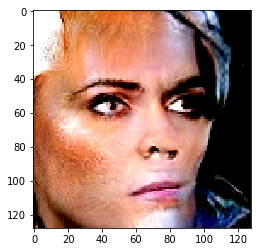

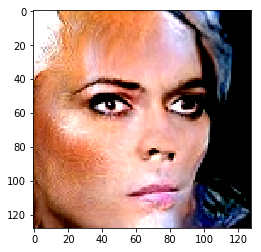

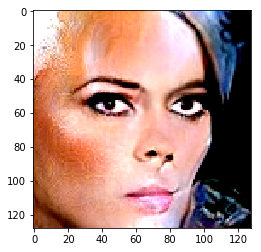

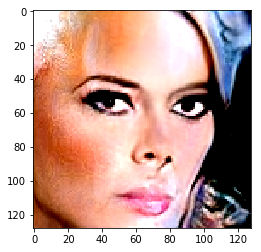

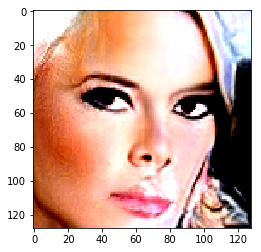

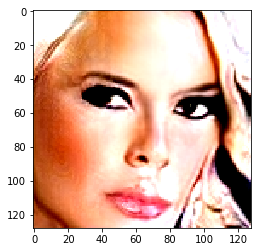

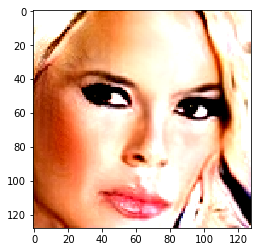

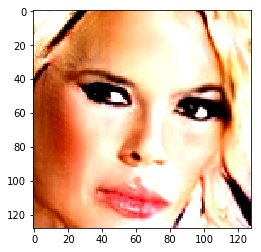

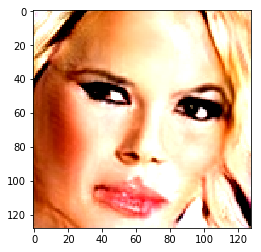

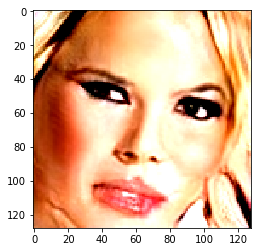

In [19]:
tf.logging.set_verbosity(tf.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

folder = "./interpolation/"
STEPS = 10
pt_a = np.random.normal(size=(512))
pt_b = np.random.normal(size=(512))
z = np.empty((STEPS, 512))
for i, alpha in enumerate(np.linspace(start=0.0, stop=1.0, num=STEPS)):
    z[i] = (1-alpha) * pt_a + alpha * pt_b

# sample all z and write out as separate images.
generator = hub.Module("https://tfhub.dev/google/progan-128/1")

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    imgs = sess.run(generator(z))
    imgs = (imgs * 255).astype(np.uint8)
    
for i, img in enumerate(imgs):
    Image.fromarray(img).save(folder + "foo_%02d.png" % i)
    np.save(folder + "z_%02d" % i, z[i])
    plt.figure()
    plt.imshow(img)

## Adding a smile (1 point + 1 point for good results)

Let's make face smiling. Find several vectors z, such that the generator generates smiling faces and not. Five vectors in every group should be enough (but the more, the better).

Calculate "smile vector" as mean of vectors z with generated smile on it minus mean of vectors z with generated not smile on it.

Look at the result of applying the smile vector: compare the results of generation before and after the addition of the smile vector.

In [20]:
def extract_latent(start_img):
    start_img.resize((128, 128), Image.ANTIALIAS)
    start_img_np = np.array(start_img)/255
    fz = tf.Variable(start_img_np, tf.float32)
    fz = tf.expand_dims(fz, 0)
    fz = tf.cast(fz,tf.float32)
    zp = tf.Variable(np.random.normal(size=(1,512)), dtype=tf.float32)
    
    # Define the optimization problem
    generator = hub.Module("https://tfhub.dev/google/progan-128/1")
    fzp = generator(zp)
    loss = tf.losses.mean_squared_error(labels=fz, predictions=fzp)

    # Decayed gradient descent
    global_step = tf.Variable(0, trainable=False)
    starter_learning_rate = 0.99
    learning_rate = tf.train.exponential_decay(starter_learning_rate,global_step, 10000, 0.005)
    opt = tf.train.GradientDescentOptimizer(learning_rate)

    #Optimize on the variable zp
    train = opt.minimize(loss, var_list=zp, global_step=global_step)

    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    for i in range(10): #200 
        _, loss_value, zp_val, eta = sess.run((train, loss, zp, learning_rate))
        #print("%03d) eta=%03f, loss = %f" % (i, eta, loss_value))

    zp_val = sess.run(zp)
    return zp_val

In [22]:
folder = "./"
smiles_latent,smiles_no_latent,smiles_imgs,smiles_no_imgs=[],[],[],[]

smile_imgs = os.listdir(folder+"Smiles_No/")
for fname in smile_imgs:
    image = Image.open(folder+"Smiles_No/" + fname)
    smiles_latent.append(extract_latent(image))
    smiles_no_imgs.append(image)

smile_imgs = os.listdir(folder+"Smiles/")
for fname in smile_imgs:
    image = Image.open(folder+"Smiles/" + fname)
    smiles_no_latent.append(extract_latent(image))
    smiles_imgs.append(image)

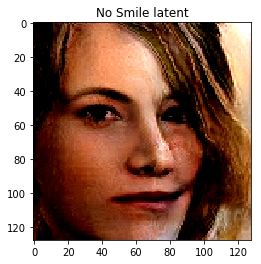

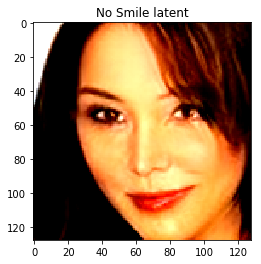

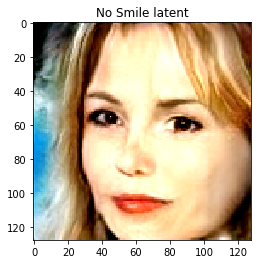

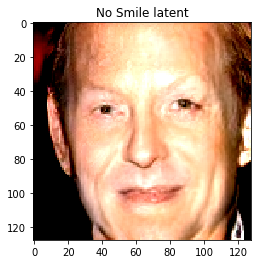

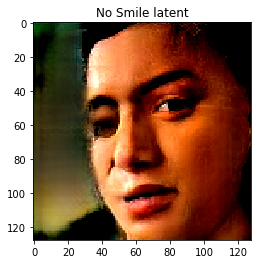

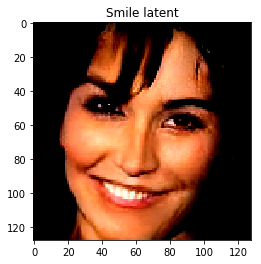

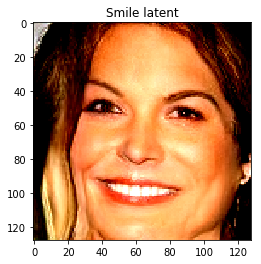

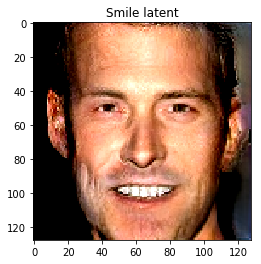

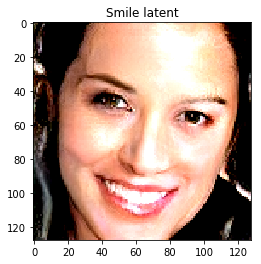

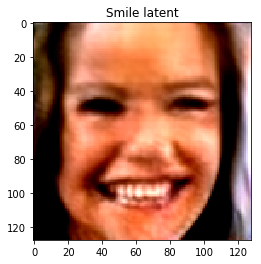

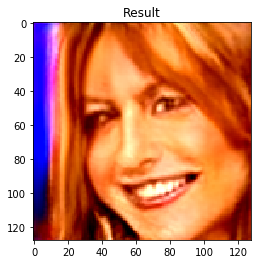

In [25]:
base_img              = Image.open(folder+"base_line.png")
base_img_latent       = extract_latent(base_img)
smiles_mean_latent    = np.mean(smiles_latent)
smiles_no_mean_latent = np.mean(smiles_no_latent)
new_latent            = base_img_latent + smiles_mean_latent - smiles_no_mean_latent

for i in range(len(smiles_no_imgs)):
    plt.figure()
    plt.title("No Smile latent")
    plt.imshow(smiles_no_imgs[i])
      
for i in range(len(smiles_imgs)):
    plt.figure() 
    plt.title("Smile latent")
    plt.imshow(smiles_imgs[i])

generator = hub.Module("https://tfhub.dev/google/progan-128/1")

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    imgs = sess.run(generator(new_latent))
    imgs = (imgs * 255).astype(np.uint8)

for i in range(len(imgs)) :
    plt.figure()
    plt.title("Result")
    plt.imshow(imgs[i])

If faces looks really cool, add bonus 1 point to your score.